# The quantum Fourier transform
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
This notebook is heavily based on [this](https://www.ryanlarose.com/uploads/1/1/5/8/115879647/shor2-qft.pdf) set of notes, which was written by our fearless leader Ryan LaRose. I highly reccomend checking out those notes for a more thorough introduction.

In [1]:
"""Imports and notebook setup."""
import warnings

import matplotlib.pyplot as plt
import numpy as np

import qiskit as qis

%matplotlib inline

if "0.9.0" not in qis.__version__:
    warnings.warn("This code is written for Qiskit v0.9.0." + 
                 "Your code may not execute properly.")

### Reminder: the *classical* Fourier transform

The quantum Foruier transfomr is an integral part of many real quantum algorithms (phase estimation, Shor, etc...). As we'll see, it is quite like regular old discrete Fourier transform, except that it Fourier transforms the *amplitudes of the wavefunction* of our set of qubits. It turns out that we can do this exponentially faster than the common fast Fourier transform (FFT), albeit with one **very** important caveat. We'll get to that later... first let's remind ourselves what a fourier transform is and how we use computers to compute them.

Let $f(t)$ be a real valued function of 'time'. The **Fourier transfrom** of $f(t)$ is definded to be

$$\mathcal{F}[f(t)] = \tilde{f}(\omega) = \int_{-\infty}^{\infty}f(t)e^{-2\pi i \omega t}dt$$

This operation is invertable: we can alyways take $\tilde{f}(t)$ and transform it back into $f(t)$ using the inverse Fourier transform

$$f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty}\tilde{f}(\omega)e^{2\pi i \omega t}d\omega$$

(As I'm sure you're aware, it is a point of general frustration as to where the $2\pi$'s and the minus signs go in the Fourier transform/inverse Fourier transform cycle. This is the verion Ryan used so I'm sticking to it.)

The Fourier transform is an esential tool in the toolbox of scientists and engieers: it allows us to pick out frequency structure in a data set that is a function of time, or to reconstruct a real space lattice from the momentum imparted on scattered x-rays. It the integral form, however, it is not very convenient for computers. To actualy compute a fourier transform, we generally use the **discrete Fourier transform** (DFT): given a discrete $N$ dimensional imput vector $f = (f_0, f_1, ..., f_{N-1})$, $\tilde{f}$ is the DFT of $f$ , and the $k^{th}$ component of $\tilde{f}$ is given by:

$$\tilde{f_k} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\omega^{kj}f_j$$

where

$$\omega = e^{i2\pi/N}$$

This is more or less equivalant to breaking up the time integral into a Reimann sum (mathmeticians, don't persecute me for saying that: I'm a lowly experimental physicist after all.) 

(Also, yes the negative sign in the exponential got thrown over to the inverse DFT. We're following the quantum computing convention here... as far as I can tell, Peter Shor just kind of decided to move the minus sign to the inverse DFT, and everyone decided that was OK. Don't shoot the messenger.)

We can see the utility of the DFT and it's common implimentation, the fast Fourier transform (FFT) by generating some test data and Fourier transforming it. Add in frequency components to the data below: you can make some absolutely wild data that you'd never be able to disentangle by eye, but the FFT can robustly pick out the frequency components you added in, even in the presence of substantial noise.

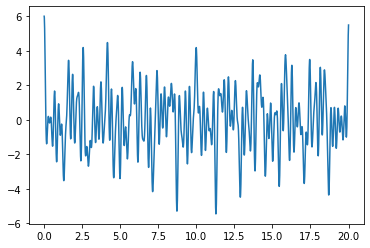

In [2]:
import scipy.fftpack as fft

#generate some complicated time data

l = 2000
x = np.linspace(0,20,l)
freqs = [0.5, 1.2, 4.3 ,2.7 ,1.9, np.pi] # add frequency components to this list to make arbitrarily complicated data
y = np.zeros(l)

for i in freqs:
    y = y + np.cos(x*i*2*np.pi) 

y = y #+ 1*np.random.rand(l) # uncomment for noise
    
plt.plot(x,y)

/home/ryan/phd/quic-seminar/semester03-fall2019/qiskit-bootcamp/code/env_qcbq/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 5)

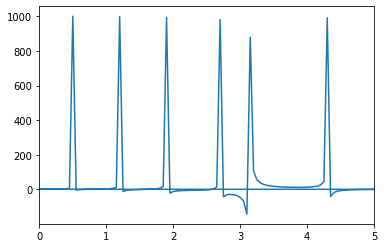

In [3]:
y_fft = fft.fft(y)

freq = fft.fftfreq(l,max(x)/l) # generate the corresponding frequency list

# the frequency components you added in will show up in the Fourier transform

fig, ax = plt.subplots()
ax.plot(freq,y_fft)
ax.set_xlim([0,5])

We recognize that the discrete Fourier transform is a linear map from $f$ to $\tilde{f}$: we can write our DFT as an $N\times N$ matrix acting on $f$: $\tilde{f} = \Omega f$. By inspecting the sum element by element, we can construct $\Omega$ with relative ease:

$$ \Omega = \frac{1}{\sqrt{N}}\begin{pmatrix} 1 & 1 & 1 & 1 & 1 \\ 1 & \omega & \omega^2 & ... & \omega^{N-1} \\ 1 & \omega^2 & \omega^4 & ... & \omega^{2(N-1)}  \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 1 & \omega^{N-1} & \omega^{2(N-1)} & ... & \omega^{(N-1)^2}  \end{pmatrix} $$

$\color{red}{\text{Exercise:}}$ Explicity construct $\Omega$ for $N = 2$, plugging in the actual number for $\omega$. What *very familiar* matrix does this look like? 

$\color{red}{\text{Another exercise:}}$ Explicity construct $\Omega$ for  $N = 4$. This matrix may not be as familiar, but as we'll see, we can construct it out of familiar matrices with relative ease.

### Let's get quantum 

It can be shown with realtive ease that $\Omega$ is in fact *unitary* (see Ryan's notes above). That means that, in principal, we can apply $\Omega$ to an $N$ dimensional quantum state vector $\ket{\psi}$. This is more or less exactly what the quantum fourier transform (confusingly called QFT) is, although it is generally presented in a slightly different notation. 

Definition of the QFT: given $N = 2^n$, where $n$ is the number of qubits let $\ket{k}$ and $\ket{j}$ be the computational basis vectors. The action of the QFT on a given computational basis vector $\ket{k}$ is defined as

$$ \ket{k} \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1}\omega^{jk}\ket{j}$$

where once again, $\omega = e^{2\pi i/2^n}$

$\color{red}{\text{Exercise:}}$ Show that, when the QFT acts on an arbitrary statevector $\ket{\psi} = \sum_k \alpha_k\ket{k}$, the resulting statevector is

$$QFT\ket{\psi} = \sum_k \beta_k\ket{k}$$

where 

$$\beta_k = \frac{1}{\sqrt{2^n}} \sum_j \omega^{jk}\alpha_{k}$$

Since we know that for $N = 2$ the matrix $\Omega$ representing the DFT is just the Hadamard (you did that exercise, right?) we can immediately see that

$$QFT_2 = H$$

It's time to build your own Quantum Fourier transform circuit! Since you guys are experts at building quantum circuits by now, I'll let you define the circuit and add the gates (OK, gate) you need to successfully implement $QFT_2$.

In [4]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ

''' 
Insert your code here! 
Define a cirucit with a 1 qubit quantum register (and a 1 bit classical register if you so desire).
Add your one qubit QFT, and draw the circuit.
'''

# answer to be deleted in distribution

q = QuantumRegister(1)     #create a three qubit circuit
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.h(q[0])
qc.measure(q[0], c[0])

qc.draw()

If you found $\Omega$ for $N = 4$, hopefully you found that

$$QFT_4 = \frac{1}{2}\begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & i & -1 & -i \\ 1 & -1 & 1 & -1 \\ 1 & -i & -1 & i \end{pmatrix} $$

At first, it doesn't look like there's a lot of structure to this matrix. However, if we *swap* columns 2 and 3, we end up with something that looks a lot more organized:

$$\tilde{QFT}_4 = \frac{1}{2}\begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & -1 & i & -i \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -i & i \end{pmatrix}  = \frac{1}{\sqrt{2}} \begin{pmatrix} H & SH \\ H & -SH\end{pmatrix}$$

Here, I've consolidated the top and bottom left $2\times 2$ blocks into Hadamards (easy to see), and consolidated the top and bottom right blocks into the phase gate multiplied by the Hadamard. As a reminder

$$ S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix}$$

$\color{red}{\text{Exercise (potentially hard!):}}$ It turns out we can decompose $\tilde{QFT}_4$ as

$$ \tilde{QFT}_4 = (H \otimes I) (\ket{0}\bra{0}\otimes I + \ket{1}\bra{1}\otimes S ) (I \otimes H) $$

Use qiskit to draw out a the two qubit circuit that executes $\tilde{QFT}_4$. To do this:

1) Remind yourself how to write out $\ket{0}\bra{0}$ and $\ket{1}\bra{1}$ as matrices

2) Show that the term in the second parentheses is actually the *controlled phase gate*

$$ CS = \begin{pmatrix} 1&0&0&0 \\  0&1&0&0 \\  0&0&1&0 \\  0&0&0&i \end{pmatrix}$$

Since the phase gate is equivalent to a $\pi/2$ rotation about the Z axis$^*$ we can impliment a phase gate in our circuit using the controlled-Z rotation gate ```crz(pi/2, q[0] ,q[1]) ``` (which reads 'rotate qubit  1 by $\pi/2$ if qubit 0 is in $\ket{1}$, otherwise do nothing')

3) Remind yourself what $I \otimes H$ means. What do I do to the first qubit, and what do I do to the second qubit?

4) Remember that when I have 3 unitary operators $A, B,$ and $C$ that I want to apply to $\ket{\psi}$ in that order, $\ket{\psi'} = CBA\ket{\psi}$

If you're bold, you can explicitly multiply out the decomposition and prove to yourself that it does infact equal the matrix $\tilde{QFT}_4$. However, if you value your time, you're free to take my word for it.

$^*$If this isn't clear to you, prove it to yourself! Since applying the phase gate twice is equivalent to a $\pi$ rotation about the Z axis, which is a $Z$ gate, sometime's you'll see it written that $S = \sqrt{Z}$

In [5]:
'''
Make a two qubit(swapped) fourier transform and draw it out!
This one may be hard, so don't be afraid to ask questions
'''

# answer to be deleted in distribution

q = QuantumRegister(2)     #create a three qubit circuit
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

qc.h(q[1])
qc.crz(np.pi/2, q[0] ,q[1])
qc.h(q[0])
#qc.measure(q[0], c[0])

qc.draw()


We're *super close* to having constructed the two qubit QFT: the last thing we need to do is remember that we swapped the $2^{nd}$ and $3^{rd}$ columns of $QFT_4$ to get $\tilde{QTF}_4$. It turns out that this is equivalent to *swapping the qubits*: we can undo this, and get the final circuit for $QFT_4$ by adding a SWAP operator at the end of our cicuit

In [6]:
''' The final two qubit QFT'''

q = QuantumRegister(2)     #create a three qubit circuit
qc = QuantumCircuit(q)

qc.h(q[1])
qc.crz(np.pi/2, q[0] ,q[1])
qc.h(q[0])
qc.swap(q[0] ,q[1])

qc.draw()


In reality, we don't actually need the SAWP operator: flipping the entire circuit upside down is just as valid

In [7]:
''' The final, slightly shorter two qubit QFT'''

q = QuantumRegister(2)     #create a three qubit circuit
qc = QuantumCircuit(q)

qc.h(q[0])
qc.crz(np.pi/2, q[1] ,q[0])
qc.h(q[1])

qc.draw()

### The general QFT
That was a lot of work for a measly 2 qubit QFT. Fortunately, since we recognize $H$ as $QFT_2$, we see that 

$$\tilde{QFT}_4 =  \begin{pmatrix} QFT_2 & SQFT_2 \\ QFT_2 & -SQFT_2\end{pmatrix}$$

It turns out that there's a recursive relationship here. In general

$$\tilde{QFT}_N =  \begin{pmatrix} QFT_{N/2} & A_{N/2}QFT_{N/2} \\ QFT_{N/2} & -A_{N/2}QFT_{N/2}\end{pmatrix}$$
where $A$ is a series of controlled rotation gates, as we'll define below. 

The pattern of the general circuit will become clear when we look at the 4 qubit QFT:


<img src="4q_QFT.png" align="middle">


Here, $R_n$ is a controlled rotation about the $Z$ axis by angle $2\pi/2^{(n+1)}$, i.e.

$$ R_n = \begin{pmatrix}1 & 0 \\ 0 & e^{2\pi i/ 2^{(n+1)}}\end{pmatrix} $$

We apply a Hadamard to the last qubit, and then a series of Z-rotation gates conditioned on all the qubits above it. We then repeat this proccess until we get to the top qubit. At the very end of the circuit, we perform SWAP operations to flip the circuit upside down (though we could have just written it upside down to begin with).  



$\color{red}{\text{Exercise:}}$ Construct a circuit in qiskit for the 5 qubit QFT. 

In [8]:
''' Construct youre circuit here'''
# answer to be deleted before distributing

q = QuantumRegister(5)     #create a three qubit circuit
qc = QuantumCircuit(q)

qc.h(q[4])
qc.crz(np.pi/2, q[3] ,q[4])
qc.crz(np.pi/4, q[2] ,q[4])
qc.crz(np.pi/8, q[1] ,q[4])
qc.crz(np.pi/16, q[0] ,q[4])

qc.barrier()

qc.h(q[3])
qc.crz(np.pi/2, q[2] ,q[3])
qc.crz(np.pi/4, q[1] ,q[3])
qc.crz(np.pi/8, q[0] ,q[3])

qc.barrier()

qc.h(q[2])
qc.crz(np.pi/2, q[1] ,q[2])
qc.crz(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[2])
qc.crz(np.pi/2, q[1] ,q[2])
qc.crz(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[1])
qc.crz(np.pi/2, q[0] ,q[1])

qc.barrier()

qc.h(q[0])

qc.barrier()

qc.swap(q[0] ,q[4])
qc.swap(q[1] ,q[3])

qc.draw()


You may notice that, even for the 5 qubit circuit, some of these rotation gates are getting pretty small. In fact, it's easy to see that as the circuit scales, the smallest rotation gets exponentially small in the circuit size. At some point it's not even worth trying to apply these small rotations: in the **approximate QFT**, we truncate the chain of rotations after some angle and forget about applying $R_k$ for some $k$ greater than some some number. This approximation speeds up our QFT algorithm, however, that even without this approximation, the quantum fourier transform is exponentially faster than even the classical fast fourier transform.  

However, we need to bring up that **very important caveat** we mentioned all the way at the top: when you compute the QFT, you're Fourier transforming the *amplitudes of the n qubit wave function*. While you may get an exponential speedup over the FFT, state tomography (reconstructing the wavefunction from measurement) requires a number of measurements that scales exponentially with the size of the system, which means I need to run my circuit an exponential number of time. If you want to Fourier transform the data you took in the lab, doing it with the QTF is a wash! Why are we even talking about this?!

The answer is that the applications of the quantum Fourier transform in quantum computing are more subtle than "Fourier transform this data set for me." The QFT acts as a sort of computational "change of basis" (just like the Hadamard, i.e. $QFT_2$, changes from the $Z$ basis to the $X$ basis and vice versa). This change of basis gets played out in action in perhapse the most famous quantum algorithm: Shor's factoring algorithm. The QFT (or, rather, it's inverse) also makes an appearence in the common [phase estimation algorithm](https://community.qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html). 


### A slightly more rigorous derivation of the circuit

As a testament to the utility of the QFT, chapter 5 of [Quantum Computing and Quantum Information](https://www.amazon.com/Quantum-Computation-Information-10th-Anniversary/dp/1107002176) (AKA Mike & Ike) is called "The quantum Fourier transform and its applications". That chapter contains a more rigourous derivation of the circuit, and an explainatin of where the QFT fits in as a subroutine to many of the most useful/powerful quantum algorithms. Hopefully, we'll cover some of those in the future!